In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [7]:
pip install moviepy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 21.2 MB/s eta 0:00:00
Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=8daf1b6e6a2d647618e97cccc707a43d7f85b6261cb950c4d0112da6e894cd9e
  Stored in directory: /Users/apple/Library/Caches/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
  Created wheel for imageio_ffmpeg: filename=imageio_ffmpeg-0.5.1-py3-none-any.whl size=16725 sha256=ed0fa028ceca3708c1e40ab81d887ad94bd928b64b112f2c349e3a29cb43e834
  Stored in directory: /Users/apple/Library/Caches/pip/wheels/a9/1f/a5/4902cfc75bc6b728b4c66e13f5e4863200337550b780ec7f33
Succ

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


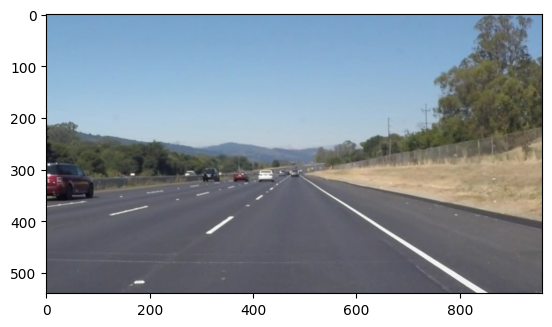

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
   
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
   
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
   
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into right_lines and left_lines, representing the right and left lane lines
    # Right/left lane lines must have positive/negative slope, and be on the right/left half of the image
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    # Run linear regression to find best fit line for right and left lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b --> x = (y - b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
   
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)


def filter_colors(image):
   
    # Filter white pixels
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
# Global parameters

# Gaussian smoothing
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
# We want a trapezoid shape, with bottom edge at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

In [6]:
def annotate_image(image_in):
   
    image = filter_colors(image_in)
    
    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny Edge Detector
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
    imshape = image.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
    initial_image = image_in.astype('uint8')
    annotated_image = weighted_img(line_image, initial_image)
    
    return annotated_image

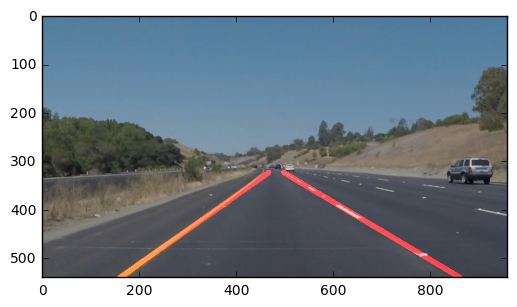

In [7]:
# Display an example image
annotated_image = annotate_image(mpimg.imread('test_images/solidYellowCurve.jpg'))
plt.imshow(annotated_image)

In [8]:

test_images = os.listdir('test_images/')

for image in test_images:
    annotated_image = annotate_image(mpimg.imread((os.path.join('test_images', image))))
    fname = image.split('.')[0] + '_annotated.jpg'  # add '_annotated' suffix to annotated image jpg file
    plt.imsave(os.path.join('test_images', fname), annotated_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = annotate_image(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 21.1 s, sys: 508 ms, total: 21.6 s
Wall time: 8.38 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:25<00:00, 26.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 7s, sys: 876 ms, total: 1min 8s
Wall time: 26.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))